In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from joblib import dump, load

from transformers import RobertaModel, RobertaTokenizer
import torch

In [2]:
MAX_SEQ_LEN = 256
BATCH_SIZE = 16
DS_SPLIT = 0.2
MIN_SPECIALITY_THRESHOLD = 100
DATASET_PATH = 'content/mtsamples.csv'

dataset = pd.read_csv(DATASET_PATH, index_col=0)
dataset.head()

,description,medical_specialty,sample_name,transcription,keywords
0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [3]:
def check_class_distribution(df):
    print("===== Class Distribution =====")
    counts = df.medical_specialty.value_counts()
    print(counts)

    plt.figure(figsize=(20, 10))
    counts.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title('Medical Specialty Counts')
    plt.xlabel('Medical Specialty')
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text


def preprocess_data(df, show_plots=False):
    # Handling Missing Values
    null_summary = df.isnull().sum()
    print(f"===== Null Summary =====\n{null_summary}")
    if null_summary.any():
        print("Dropping rows with missing values...")
        df = df.dropna()

    # Checking for Duplicate Values
    duplicate_count = df.duplicated().sum()
    print(f"===== Duplicate Summary =====\nCount: {duplicate_count}")
    if duplicate_count > 0:
        print("Dropping duplicate rows...")
        df = df.drop_duplicates()

    df['transcription_clean'] = df['transcription'].map(clean_text)

    if show_plots:
        check_class_distribution(df)
    return df

<class 'pandas.core.frame.DataFrame'>
Index: 4999 entries, 0 to 4998
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   medical_specialty  4999 non-null   object
 1   transcription      4966 non-null   object
dtypes: object(2)
memory usage: 117.2+ KB
None
===== Null Summary =====
medical_specialty     0
transcription        33
dtype: int64
Dropping rows with missing values...
===== Duplicate Summary =====
Count: 2
Dropping duplicate rows...
===== Class Distribution =====
medical_specialty
Surgery                          1088
Consult - History and Phy.        516
Cardiovascular / Pulmonary        371
Orthopedic                        355
Radiology                         273
General Medicine                  259
Gastroenterology                  224
Neurology                         223
SOAP / Chart / Progress Notes     166
Urology                           156
Obstetrics / Gynecology           155
Discharg

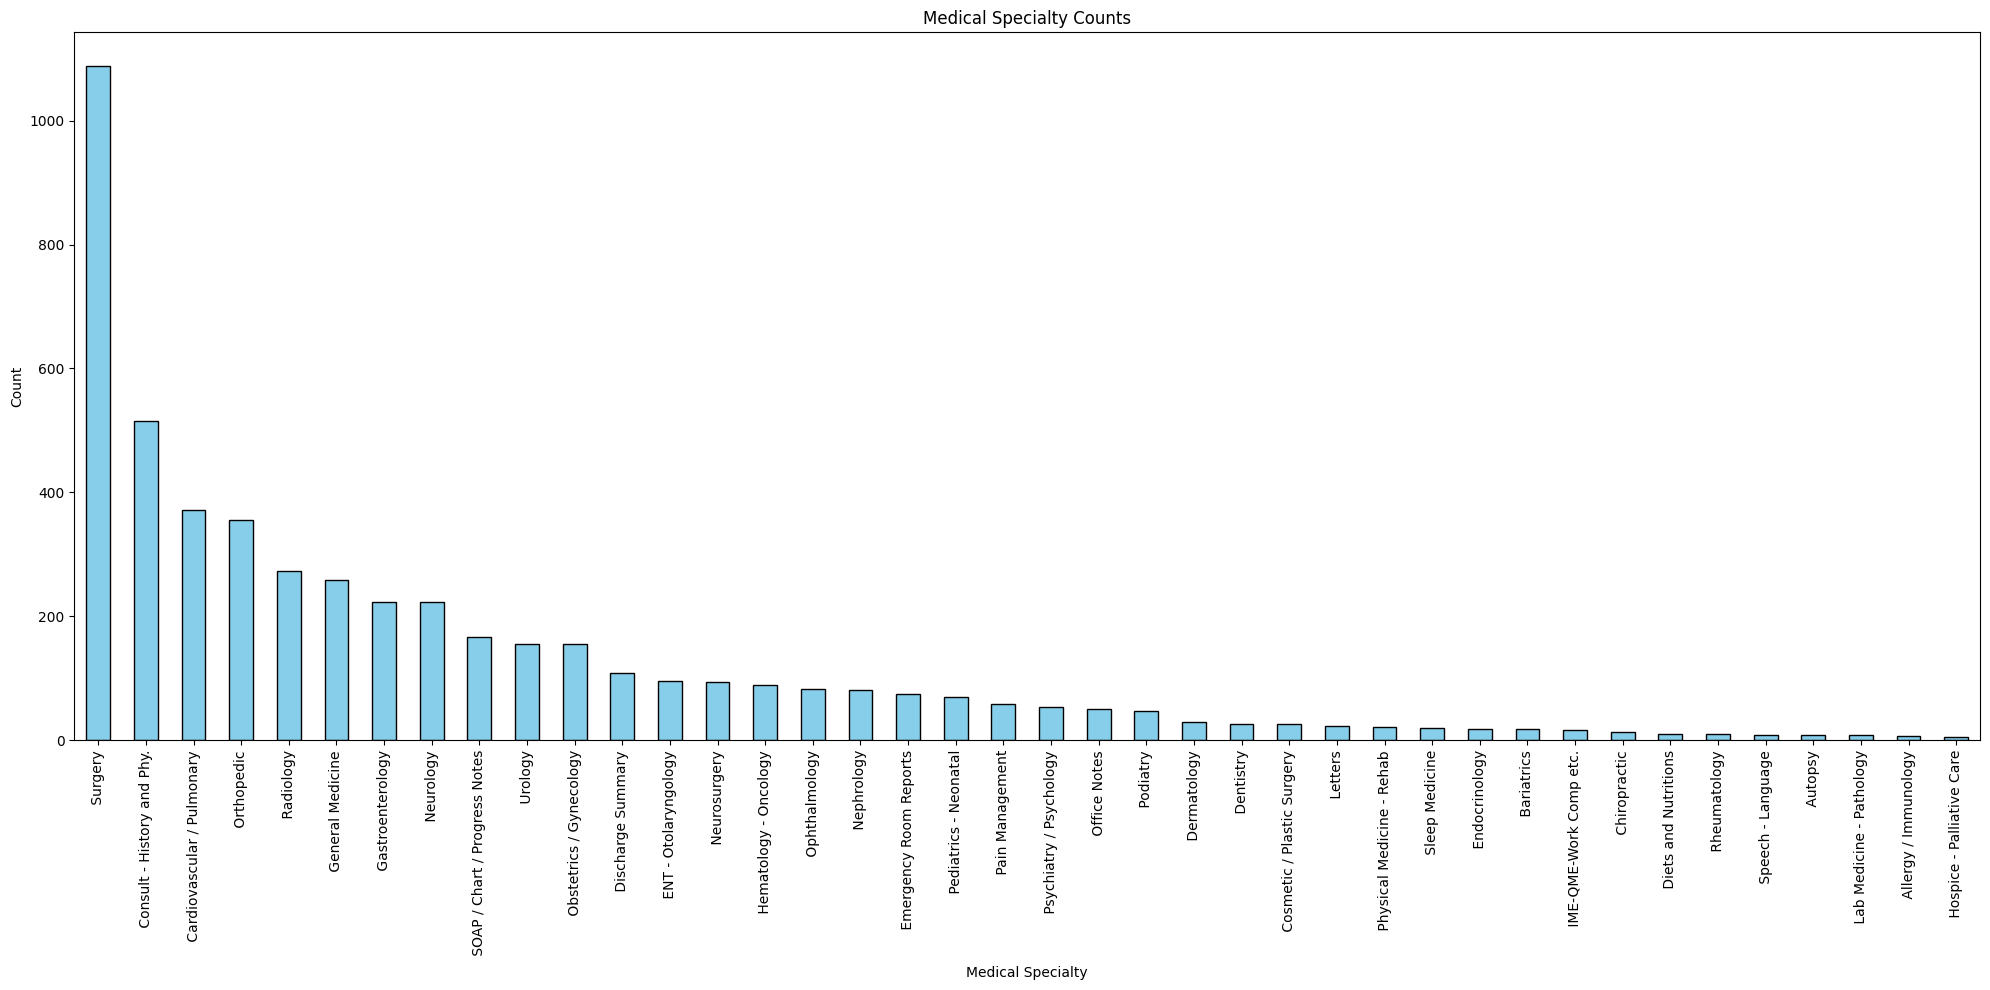

In [4]:
sub_ds = dataset[['medical_specialty', 'transcription']]
print(sub_ds.info())
sub_ds = preprocess_data(sub_ds, show_plots=True)

In [5]:
sub_ds['medical_specialty_code'] = pd.factorize(sub_ds['medical_specialty'])[0]
print(f"Shape: {sub_ds.shape}")
sub_ds.head()

Shape: (4964, 4)


,medical_specialty,transcription,transcription_clean,medical_specialty_code
0,Allergy / Immunology,"SUBJECTIVE:, This 23-year-old white female pr...",subjective this 23 year old white female prese...,0
1,Bariatrics,"PAST MEDICAL HISTORY:, He has difficulty climb...",past medical history he has difficulty climbin...,1
2,Bariatrics,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...",history of present illness i have seen abc tod...,1
3,Cardiovascular / Pulmonary,"2-D M-MODE: , ,1. Left atrial enlargement wit...",2 d m mode 1 left atrial enlargement with left...,2
4,Cardiovascular / Pulmonary,1. The left ventricular cavity size and wall ...,1 the left ventricular cavity size and wall th...,2


In [17]:
speciality_count = sub_ds.medical_specialty.value_counts()
filtered_ds = sub_ds[sub_ds.medical_specialty.isin(speciality_count[speciality_count >= MIN_SPECIALITY_THRESHOLD].index)]
filtered_ds.medical_specialty.value_counts()

medical_specialty
Surgery                          1088
Consult - History and Phy.        516
Cardiovascular / Pulmonary        371
Orthopedic                        355
Radiology                         273
General Medicine                  259
Gastroenterology                  224
Neurology                         223
SOAP / Chart / Progress Notes     166
Urology                           156
Obstetrics / Gynecology           155
Discharge Summary                 108
Name: count, dtype: int64

In [7]:
# define X and y
X = filtered_ds['transcription_clean'].tolist()
y = filtered_ds['medical_specialty_code'].tolist()

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaModel.from_pretrained('roberta-base')

# Tokenize X
inputs = tokenizer(X, padding=True, truncation=True, return_tensors="pt", max_length=MAX_SEQ_LEN)

# generate embeddings in batches
def generate_embeddings(model, inputs, batch_size=BATCH_SIZE):
    model.eval()
    embeddings = []
    for i in range(0, inputs['input_ids'].size(0), batch_size):
        batch_input_ids = inputs['input_ids'][i:i+batch_size]
        batch_attention_mask = inputs['attention_mask'][i:i+batch_size]
        with torch.no_grad():
            batch_outputs = model(batch_input_ids, attention_mask=batch_attention_mask)
            batch_embeddings = batch_outputs.last_hidden_state.mean(dim=1)
            embeddings.append(batch_embeddings.cpu().numpy())
    embeddings = np.concatenate(embeddings, axis=0)
    return embeddings

# Generate embeddings
embeddings = generate_embeddings(model, inputs, batch_size=BATCH_SIZE)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
ros = RandomOverSampler(random_state=42)
embeddings_resampled, labels_resampled = ros.fit_resample(embeddings, y)
X_train, X_test, y_train, y_test = train_test_split(embeddings_resampled, labels_resampled, test_size=DS_SPLIT, random_state=42)
print(f"Resampled embeddings shape: {len(embeddings_resampled)}, Resampled labels shape: {len(labels_resampled)}")

Resampled embeddings shape: 13056, Resampled labels shape: 13056


In [15]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=3, scoring='f1_weighted')
grid_search.fit(X_train, y_train)
best_rf_model = grid_search.best_estimator_

print("Best parameters found: ", grid_search.best_params_)
print("Best weighted F1 score found: ", grid_search.best_score_)

dump(grid_search, 'content/grid_search_rf.joblib')

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters found:  {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best weighted F1 score found:  0.6559063737299059


['content/grid_search_rf.joblib']

In [16]:
y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           2       0.61      0.58      0.59       212
           3       0.67      0.70      0.69       224
           5       0.82      0.91      0.87       235
           6       0.60      0.56      0.57       218
           7       0.59      0.23      0.33       214
           9       0.71      0.87      0.78       229
          12       0.50      0.56      0.53       213
          18       0.66      0.66      0.66       214
          21       0.83      0.90      0.87       220
          29       0.78      0.81      0.79       193
          33       0.78      0.96      0.86       216
          37       0.51      0.43      0.47       224

    accuracy                           0.68      2612
   macro avg       0.67      0.68      0.67      2612
weighted avg       0.67      0.68      0.67      2612

